# Import Libraries and define directories

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import ast
from pathlib import Path

from scipy.stats import spearmanr
from tqdm.autonotebook import tqdm
from src.data_preparation import run_gypsumdl
from IPython.display import display, Image
from sklearn.model_selection import train_test_split
from src.docking import *
from src.utilities import get_selected_workflow
from src.rescoring import rescoring_function
from src.preprocessing import merge_activity_values, hdbscan_scaffold_split, cv_split, norm_scores
from src.pose_score_optimization import scores_preprocessing, score_pose_optimization, prepare_parameters, prediction, mapping_normalized_weights
from src.interaction_analysis import (
    split_sdf_path, 
    actives_extraction, 
    plipify_fp_interaction, 
    indiviudal_interaction_fp_generator, 
    read_interactions_json, 
    interactions_aggregation
)

from src.ranking import enrichment_factor_calc
import matplotlib.pyplot as plt

from pathlib import Path

In [49]:
protein_name  = 'test_data/5UG9_noligand_protoss.pdb'
ligand_library = 'test_data/test_three_cpds.sdf'
reference_ligand = 'test_data/ref_ligand.pdb'

In [50]:
HERE = Path(_dh[-1])
software = (HERE / "software")
protein_path = (HERE  / protein_name)
known_ligand_library = (HERE / ligand_library)
ref_file = (HERE /  reference_ligand)


OUTPUT = HERE / "output"
OUTPUT.mkdir(exist_ok=True)

# MolDockLab Workflow

## Prepare ligands library

In [4]:
output_prepared_mols = HERE / f"{known_ligand_library.stem}_prepared.sdf"
run_gypsumdl(
    ligand_library=known_ligand_library, 
    prepared_library_path=output_prepared_mols, 
    id_column="chembl_id"
    )

Molecules are already prepared by Gypsum-DL


## Consensus Docking

In [7]:
docking_programs = [
                'GNINA', 
                'SMINA',
                'diffdock', 
                'PLANTS', 
                # 'flexx',
                ]

n_poses = 3
exhaustiveness = 8

In [8]:
from src.docking import docking

docking(
        docking_programs,
        protein_path,
        output_prepared_mols,
        ref_file,
        exhaustiveness,
        n_poses,
        OUTPUT,
        local_diffdock=False
        )



Docking with GNINA is running ...

Compounds are already docked with GNINA v 1.0


Docking with SMINA is running ...

Compounds are already docked with SMINA


Docking with DIFFDOCK is running ...

Binding pocket is already extracted


DiffDock / Local DiffDock is running ...: 100%|██████████| 3/3 [00:00<00:00, 17236.87it/s]

Compound CHEMBL460721 is already docked with DiffDock
Compound CHEMBL4858409 is already docked with DiffDock
Compound CHEMBL3133894 is already docked with DiffDock
ERROR: [Errno 20] Not a directory: '/home/hamza/github/MolDockLab/ECFT-VS-pipeline/output/diffdock/diffdock_poses.sdf'

Compounds are already docked and concatenated, CHECK /home/hamza/github/MolDockLab/ECFT-VS-pipeline/output/diffdock/diffdock_poses.sdf


Docking with PLANTS is running ...

PLANTS preprocessing is running ...
	 Converting to Mol2
		5UG9_noligand_protoss is already converted to MOL2 format
		test_three_cpds_prepared is already converted to MOL2 format
		ref_ligand is already converted to MOL2 format
PLANTS bind mode is executed.
Compounds are already docked with PLANTS


Concatenating all poses in one SDF file ...

Compounds are already docked and concatenated, CHECK /home/hamza/github/MolDockLab/ECFT-VS-pipeline/output/allposes.sdf


### PoseBusters for quality checking

In [10]:
protein_name = '5UG9_noligand_protoss'
docking_tools_results = poses_checker(
    poses_path= OUTPUT / 'allposes.sdf', 
    protein_path= protein_path, 
    output_file= OUTPUT / f'{protein_name}_posebusters_results.csv'
    )
docking_tools_results

PoseBusters was executed


,docking_tool,internal_energy,minimum_distance_to_protein,volume_overlap_with_protein,Number of Docked Molecules
0,diffdock,0,30,16,3
1,gnina,3,0,0,3
2,plants,0,1,0,3
3,smina,2,0,0,3


## Scoring Functions

In [13]:
rescoring = [
    'cnnscore', 
    'cnnaffinity',  
    'smina_affinity',
    # 'ad4',  
    'linf9', 
    'rtmscore', 
    'vinardo', 
    # 'scorch',
    # 'hyde', 
    'chemplp', 
    'rfscore_v1',
    # 'rfscore_v2',
    'rfscore_v3', 
    'vina_hydrophobic', 
    'vina_intra_hydrophobic'
    ]

In [14]:
docked_library_path = OUTPUT / f"allposes.sdf"

rescoring_function(
    rescoring,
    protein_path,
    docked_library_path,
    ref_file,
    ncpu=6,
)

protein is already converted to mol2
protein is already converted to mol2


Now rescoring with CNNSCORE ... ⌛⌛ 
cnnscore is already excuted
cnnscore is already read


Now rescoring with CNNAFFINITY ... ⌛⌛ 
cnnaffinity is already excuted
cnnaffinity is already read


Now rescoring with SMINA_AFFINITY ... ⌛⌛ 
smina_affinity is already excuted
smina_affinity is already read


Now rescoring with LINF9 ... ⌛⌛ 
linf9 is already excuted
linf9 is already read


Now rescoring with RTMSCORE ... ⌛⌛ 
rtmscore is already excuted
rtmscore is already read


Now rescoring with VINARDO ... ⌛⌛ 
vinardo is already excuted
vinardo is already read
sdf_0.sdf is converted to mol2
sdf_1.sdf is converted to mol2
sdf_2.sdf is converted to mol2
sdf_3.sdf is converted to mol2
sdf_4.sdf is converted to mol2
sdf_5.sdf is converted to mol2


Now rescoring with CHEMPLP ... ⌛⌛ 
chemplp is already excuted
chemplp is already read


Now rescoring with RFSCORE_V1 ... ⌛⌛ 
rfscore_v1 is already excuted
rfscore_v1 is already

### Scores Normalization

#### Merging true value and splitting

In [17]:
df_rescored_merged = merge_activity_values(
    norm_scored_path = OUTPUT / 'rescoring_results' / 'all_rescoring_results.csv', 
    mols_true_value_path = known_ligand_library,
    true_value_col = 'true_value',
    scored_id_col='ID',
    activity_col='activity_class',
    lower_better_true_value = False,
    threshold=0.9
    )

Scores of {'rfscore_v3', 'smina_affinity', 'Vinardo'} were found to highly correlate. Therefore, they are removed.


## Scaffold split for versatility checking 
- It can be done for more data points

In [18]:
# clustered_df = hdbscan_scaffold_split(ligand_library, min_cluster_size=2)
# cv_split(clustered_df, df_rescored_merged, idx_col='ID', n_splits=2, output_path= DATA / 'data_splits', target_name='egfr')

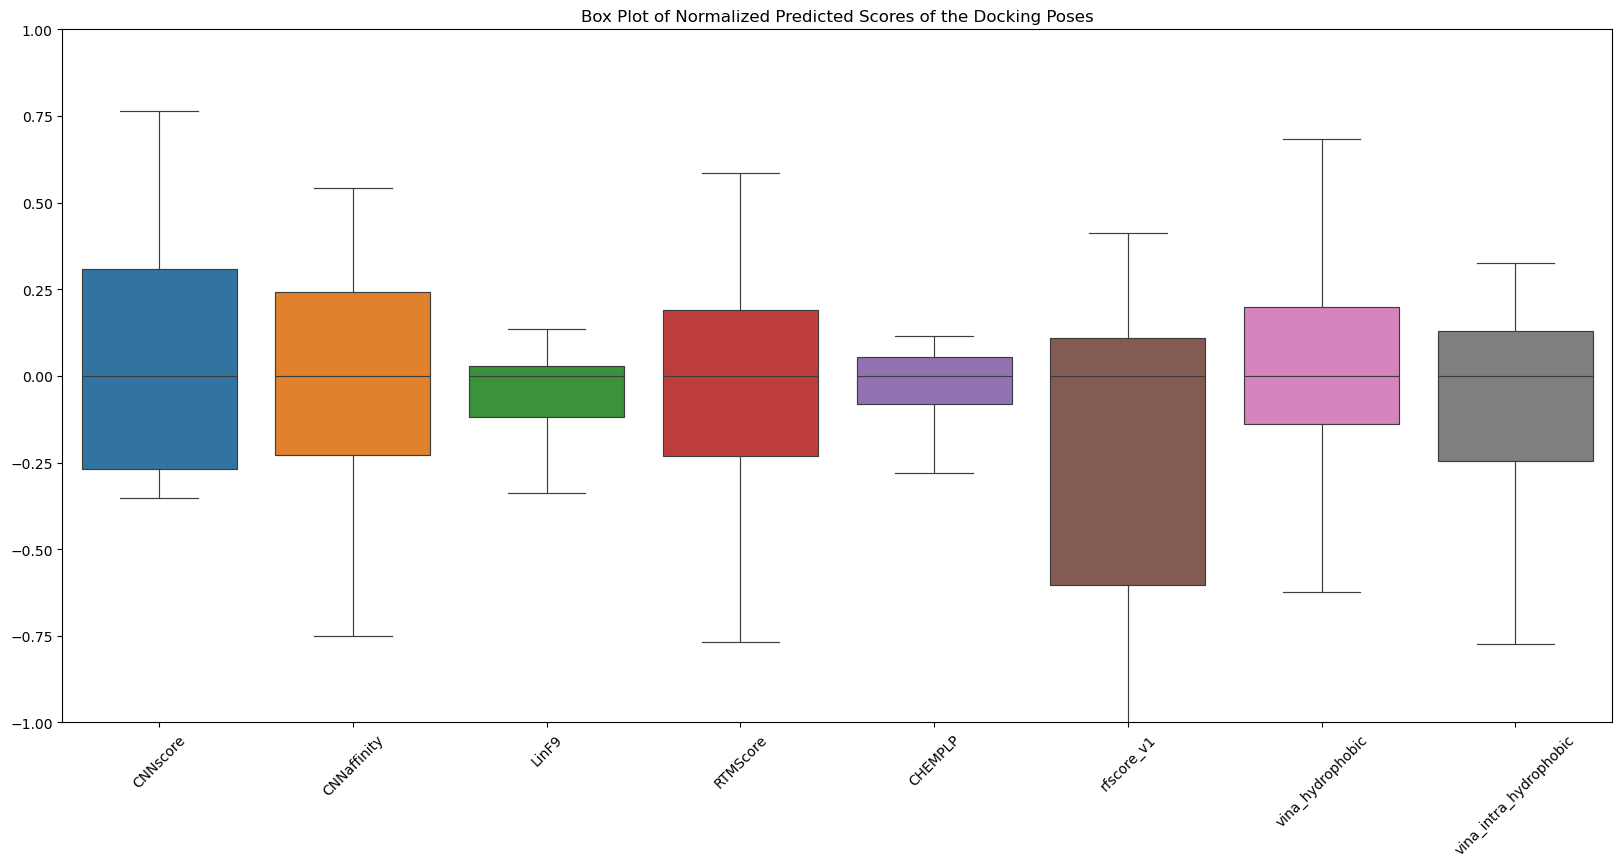

In [19]:
norm_scored_path = OUTPUT / 'all_rescoring_results_merged_norm_robust.csv'
# df_rescored = pd.read_csv(str(OUTPUT / 'all_rescoring_results.csv'))

df_rescored_norm = norm_scores(df_rescored_merged)

plt.figure(figsize=(20, 9))
sns.boxplot(data=df_rescored_norm.drop(columns=['activity_class', 'true_value']) ,linewidth=.85, showfliers=False)
plt.ylim(-1, 1)
plt.title('Box Plot of Normalized Predicted Scores of the Docking Poses')
plt.xticks(rotation=45) 
plt.show()

df_rescored_norm.to_csv(str(norm_scored_path), index=False)

## Pose Score Optimization

### Executing optimization function for different regularization

In [24]:
regs = [0.1]
X, y, docking_cost, scoring_cost, docking_tools, scoring_tools = scores_preprocessing(df_rescored_merged.drop(columns=['activity_class']))
best_weights = score_pose_optimization(X, y, docking_cost, scoring_cost, weights_path = OUTPUT / 'best_weights.npy', alphas=regs, iter=500)
best_weights

100%|██████████| 120/120 [00:00<00:00, 11650.31it/s]


Optimization with Regularization: 0.1


  0%|          | 0/500 [00:00<?, ?it/s]/home/hamza/github/MolDockLab/ECFT-VS-pipeline/src/pose_score_optimization.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c = torch.tensor(x)
100%|██████████| 500/500 [00:49<00:00, 10.08it/s]


{0.1: array([ 5.01024579e-01,  3.53690393e-02,  9.50235957e-01, -3.72487779e-03,
         3.27468445e-01,  4.97510692e-01, -1.04484540e-01,  2.74286656e-01,
         1.91093199e-07, -1.21512645e-06,  2.69821442e-05, -1.07849307e-07])}

### Check the correlation of each alpha with the true value

In [25]:
for alpha in best_weights.keys():
    c_r, c_d = prepare_parameters(best_weights[alpha], X.shape[1])
    preds = pd.DataFrame({'prediction': prediction(c_r, c_d, X), 'ground truth': y})
    corr = preds.corr('spearman')['ground truth']['prediction']
    # sns.lmplot(data=preds, x='prediction', y='ground truth')
    print(f"Using alpha {alpha} give a correlation of : {corr}")

Using alpha 0.1 give a correlation of : 0.5


### Mapping the normalized weights to docking tools and scoring functions

In [26]:
selected_docking = {}
selected_rescoring = {}
for alpha in best_weights.keys():
    normalized_weights = mapping_normalized_weights(best_weights[alpha], scoring_tools, docking_tools)
    print(f"Using alpha {alpha} give normalized weights: \n{normalized_weights}\n")
    #extract the tools that is above 0.5 in a list
    selected_docking[alpha] = [key for key, value in list(normalized_weights.items())[:5] if value > 0.5]
    selected_rescoring[alpha] = [key for key, value in list(normalized_weights.items())[6:] if value > 0.5]
    print(f"Using alpha {alpha} give selected tools: \n For Docking:{selected_docking[alpha]}\n For Rescoring:{selected_rescoring[alpha]}\n")

Using alpha 0.1 give normalized weights: 
{'diffdock': 0.04987077161790204, 'gnina': 0.0, 'plants': 1.0, 'smina': 0.03926894741184088, 'CNNscore': 0.5740943889966865, 'CNNaffinity': 0.1325977639087437, 'LinF9': 1.0, 'RTMScore': 0.09553209845107365, 'CHEMPLP': 0.40954261001615233, 'rfscore_v1': 0.5707628071831404, 'vina_hydrophobic': 0.0, 'vina_intra_hydrophobic': 0.3591199728081151}

Using alpha 0.1 give selected tools: 
 For Docking:['plants', 'CNNscore']
 For Rescoring:['LinF9', 'rfscore_v1']



In [27]:
ranking_methods = [
                'best_ECR' ,
                'ECR_average',
                'average_ECR' ,
                'rank_by_rank' ,
                'rank_by_vote' ,
                'rank_by_number',
                'best_Zscore',
                'average_Zscore',
                'weighted_ECR'
                ]

In [29]:
from src.ranking import *
poses_ranking(
ranking_methods=ranking_methods,
df_rescored=df_rescored_norm,
output_path=OUTPUT,
weights=normalized_weights,
)

Number of docking programs: 4, ['diffdock', 'gnina', 'plants', 'smina']
Number of rescoring methods: 8, ['CNNscore', 'CNNaffinity', 'LinF9', 'RTMScore', 'CHEMPLP', 'rfscore_v1', 'vina_hydrophobic', 'vina_intra_hydrophobic']
Number of possible combinations for every ranking method: 3825
 With total combinations : 34425
All poses are ranked with all consensus methods ..


### Visualize consensus SBVS workflow

In [30]:
corr_df = pd.read_csv(OUTPUT / f'correlations_general/all_ranked.csv')
corr_df.head(10)

,docking_tool,scoring_function,spearman_correlation,cost_per_pipeline,enrichment_factor,ranking_method
0,"['diffdock', 'gnina', 'plants']",['CHEMPLP'],1.0,521.33,0,method1_ECR_best
1,"['gnina', 'plants', 'smina']","['CHEMPLP', 'LinF9']",1.0,216.13,0,method1_ECR_best
2,"['plants', 'smina']","['CHEMPLP', 'LinF9']",1.0,110.33,0,method1_ECR_best
3,"['gnina', 'plants']","['CHEMPLP', 'CNNscore']",1.0,116.93,0,method1_ECR_best
4,"['gnina', 'plants']","['CHEMPLP', 'vina_intra_hydrophobic']",1.0,120.73,0,method1_ECR_best
5,"['plants', 'smina']","['CHEMPLP', 'vina_hydrophobic']",1.0,114.83,0,method1_ECR_best
6,"['diffdock', 'plants']","['CHEMPLP', 'RTMScore']",1.0,419.63,0,method1_ECR_best
7,"['diffdock', 'plants']","['CHEMPLP', 'CNNscore', 'RTMScore']",1.0,422.73,0,method1_ECR_best
8,"['diffdock', 'plants']",['CHEMPLP'],1.0,415.53,0,method6_Zscore_best
9,"['diffdock', 'plants']","['CHEMPLP', 'LinF9']",1.0,417.93,0,method6_Zscore_best


In [31]:
# select best balanced workflow by looking into a range of max 0.05 difference in spearman correlation and select the one with lowest enrichment factor and not less than 0.5 in enrichment_factor

range_workflows = corr_df[(corr_df['spearman_correlation'] >= corr_df['spearman_correlation'].max() - 0.05) &
                          (corr_df['enrichment_factor'] >= corr_df.loc[0, 'enrichment_factor'] - 0.5)]
# select row with the minimum cost value
range_workflows.loc[range_workflows['cost_per_pipeline'].idxmin()]

docking_tool                     ['plants']
scoring_function                ['CHEMPLP']
spearman_correlation                    1.0
cost_per_pipeline                      8.03
enrichment_factor                         0
ranking_method          method6_Zscore_best
Name: 217, dtype: object

# Deploying optimal balanced SBVS workflow
- By default, workflows within 5% from highest spearman correlation and 0.5 enrichment factor with least runtime cost is selected

In [71]:
selected_workflows = corr_df[(corr_df['spearman_correlation'] >= corr_df['spearman_correlation'].max() - 0.05) &
                          (corr_df['enrichment_factor'] >= corr_df.loc[0, 'enrichment_factor'] - 0.5)]
# select row with the minimum cost value
selected_workflow = range_workflows.loc[range_workflows['cost_per_pipeline'].idxmin()]

selected_docking_tools = ast.literal_eval(selected_workflow['docking_tool'])
selected_scoring_functions = ast.literal_eval(selected_workflow['scoring_function'])
selected_ranking_method = selected_workflow['ranking_method']

print(f"Docking tools: {(selected_docking_tools)}\nScoring tools: {selected_scoring_functions}\nRanking method: {ranking_method}")

Docking tools: ['plants']
Scoring tools: ['CHEMPLP']
Ranking method: method6_Zscore_best


## Directory for larger Dataset

In [59]:
larger_data_output = OUTPUT / "larger_data_output"
larger_data_output.mkdir(exist_ok=True)

## Ligands preparation

In [38]:
sbvs_ligands_library = (HERE / 'test_data/test_library_10cpds.sdf')
prepared_chembl_data_path = larger_data_output / f"{sbvs_ligands_library.stem}_prepared.sdf"
run_gypsumdl(str(prepared_chembl_data_path), prepared_chembl_data_path)

Molecules are already prepared by Gypsum-DL


## Molecular Docking of selected tools

In [43]:
docking(
        docking_methods=selected_docking_tools,
        protein_path=protein_path,
        ligands_path=prepared_chembl_data_path,
        ref_file=ref_file,
        exhaustiveness=32,
        n_poses=10,
        OUTPUT=larger_data_output
        )



Docking with PLANTS is running ...

PLANTS preprocessing is running ...
	 Converting to Mol2
		5UG9_noligand_protoss is already converted to MOL2 format
		ref_ligand is already converted to MOL2 format
PLANTS bind mode is executed.
Compounds are already docked with PLANTS


Concatenating all poses in one SDF file ...

Compounds are already docked and concatenated, CHECK /home/hamza/github/MolDockLab/ECFT-VS-pipeline/output/larger_data_output/allposes.sdf


## Interaction hotspots detection using PLIPify

In [46]:
actives_path = actives_extraction( 
    OUTPUT / 'allposes.sdf', 
    OUTPUT / 'rescoring_results/all_rescoring_results_merged.csv', 
    docking_tool=selected_docking_tools
    )

actives_paths = split_sdf_path(actives_path)

Number of active compounds: 10


SDF splitting: 100%|██████████| 10/10 [00:00<00:00, 2386.25it/s]


100%|██████████| 10/10 [00:01<00:00,  5.36it/s]


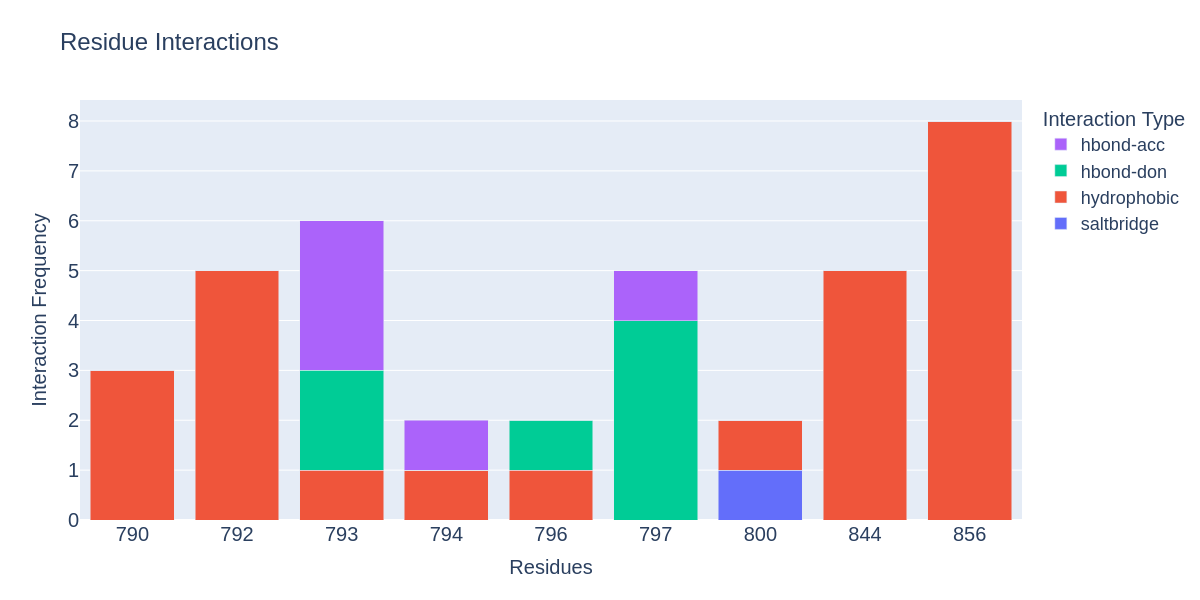

In [53]:
# if more than chain, write in a list
chain = 'X'
protein_name = protein_path.stem

interx_csv = OUTPUT / f'{protein_path.stem}_{chain}_interx.csv'
fp_focused = plipify_fp_interaction(
    ligands_path=actives_paths, 
    protein_path=protein_path, 
    protein_name='EGFR', 
    chains=chain,
    output_file=OUTPUT / f'{protein_name}_interactions_{chain}.png'
    )
fp_focused['total_interactions'] = fp_focused.sum(axis=1)
display(Image(filename=OUTPUT / f'{protein_name}_interactions_{chain}.png'))

## Interaction fingerprints generations

In [54]:
included_chains = ['X']
protein_name = 'egfr'
interactions_dict_path = larger_data_output / 'fp_allposes.json'
ligands_paths = split_sdf_path(larger_data_output / 'allposes.sdf')
allposes_interaction_fp = indiviudal_interaction_fp_generator(ligands_paths, 
                                                              protein_path, 
                                                              protein_name, 
                                                              included_chains, 
                                                              interactions_dict_path)

SDF splitting:   0%|          | 0/100 [00:00<?, ?it/s]

SDF splitting: 100%|██████████| 100/100 [00:00<00:00, 3676.51it/s]


JSON file saved to /home/hamza/github/MolDockLab/ECFT-VS-pipeline/output/larger_data_output/fp_allposes.json


In [55]:
interactions_df = read_interactions_json(
    json_file=interactions_dict_path, 
    output_file=larger_data_output / 'allposes_interaction_fps_final.csv'
    )
        
interactions_df  

Interactions are converted to CSV file.


,Poses,741X,775X,790X,791X,792X,793X,794X,795X,796X,797X,800X,841X,842X,844X,854X,856X
0,CHEMBL1830130_plants_01,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1
1,CHEMBL1830130_plants_02,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1
2,CHEMBL1830130_plants_03,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1
3,CHEMBL1830130_plants_04,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1
4,CHEMBL1830130_plants_05,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,CHEMBL5088102_plants_06,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
96,CHEMBL5088102_plants_07,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0
97,CHEMBL5088102_plants_08,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
98,CHEMBL5088102_plants_09,0,0,0,1,1,1,0,0,0,0,0,0,0,1,1,1


## Frequent interactions found in active compounds are used as key interactions
- By default top four interactions in actives are used for interactions filtration

In [56]:
key_interactions_resno = list(fp_focused.sort_values(by='total_interactions', ascending=False).head(4).index)
chain = 'X'
key_interactions_resno = [f'{resno}{chain}' for resno in key_interactions_resno]
print(f"Key interactions with residues are: {key_interactions_resno}")

Key interactions with residues are: ['856X', '793X', '844X', '797X']


In [60]:
agg_interx_df = interactions_aggregation(
                     interactions_df=interactions_df.reset_index(),
                     important_interactions=key_interactions_resno,
                     id_column='Poses'
                    )
agg_interx_df.replace(0, np.nan, inplace=True)
agg_interx_df.dropna(inplace=True)
agg_interx_df.to_csv(larger_data_output / 'selected_ligands_interaction.csv', index=False)

agg_interx_df

,id,856X,793X,844X,797X
1,CHEMBL2424807,8,5,7,1.0
2,CHEMBL255871,3,9,10,4.0
3,CHEMBL3425665,10,9,7,4.0
4,CHEMBL4068047,4,8,9,5.0
5,CHEMBL4074615,9,7,6,5.0
6,CHEMBL4164936,8,1,10,1.0
7,CHEMBL4457733,8,7,6,3.0
8,CHEMBL504173,6,7,8,1.0
9,CHEMBL5088102,9,5,9,4.0


## Selected Scoring functions for correlation pipeline

In [61]:
docked_library_path = larger_data_output / "allposes.sdf"

rescoring_function(
    selected_scoring_functions,
    protein_path,
    docked_library_path,
    ref_file,
    ncpu=7,
)

sdf_0.sdf is converted to mol2
sdf_1.sdf is converted to mol2
sdf_2.sdf is converted to mol2
sdf_3.sdf is converted to mol2
sdf_4.sdf is converted to mol2
sdf_5.sdf is converted to mol2
sdf_6.sdf is converted to mol2


Now rescoring with CHEMPLP ... ⌛⌛ 
chemplp is already excuted
chemplp is already read


Rescoring results are merged successfully 🎉🎉


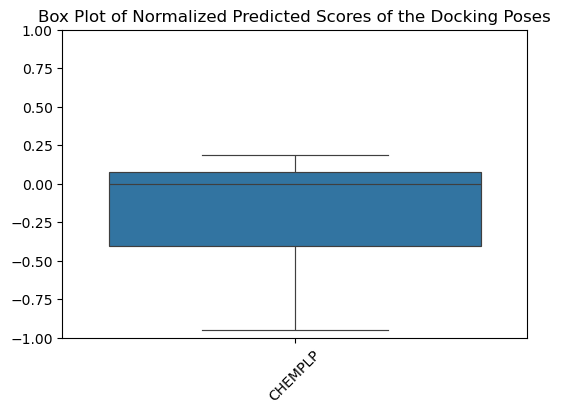

In [63]:
norm_scored_path = larger_data_output / 'rescoring_results' / 'all_rescoring_results_norm_robust.csv'
df_rescored = pd.read_csv(str(larger_data_output / 'rescoring_results' / 'all_rescoring_results.csv'))

df_rescored_norm = norm_scores(df_rescored)

plt.figure(figsize=(6, 4))
sns.boxplot(data=df_rescored_norm ,linewidth=.85, showfliers=False)
plt.ylim(-1, 1)
plt.title('Box Plot of Normalized Predicted Scores of the Docking Poses')
plt.xticks(rotation=45) 
plt.show()

df_rescored_norm.to_csv(str(norm_scored_path), index=False)

In [64]:
rescored_library = pd.read_csv(str(norm_scored_path))
rescored_library['id'] = rescored_library.ID.str.split('_').str[0]

## Selected Ranking Method

In [75]:
from src.consensus_rank import *
ranking_methods_dict = {  
    'method1_ECR_best' : method1_ECR_best, 
    'method2_ECR_average' : method2_ECR_average, 
    'method3_avg_ECR' : method3_avg_ECR,
    'method4_RbR' : method4_RbR,
    'method5_RbV' : method5_RbV,
    'method6_Zscore_best': method6_Zscore_best,
    'method7_Zscore_avg': method7_Zscore_avg,
    'method8_RbN': method8_RbN,
    'method9_weighted_ECR_best': method9_weighted_ECR_best
    }
ranked_sbvs_ligands = ranking_methods_dict[selected_ranking_method](
    rescored_library,
    weight=0.5, 
    selected_scores=selected_scoring_functions,
    id_column='id'
    )

ranked_sbvs_ligands = ranked_sbvs_ligands.sort_values(by=ranked_sbvs_ligands.columns[-1], ascending=False)
ranked_sbvs_ligands.to_csv(larger_data_output / 'ranked_ligands.csv', index=False)

ranked_sbvs_ligands

,id,method6_Zscore_best
50,CHEMBL255871,1.046731
0,CHEMBL4457733,0.914210
60,CHEMBL2424807,0.894773
90,CHEMBL3425665,0.805564
30,CHEMBL504173,0.752375
20,CHEMBL1830130,0.730077
70,CHEMBL5088102,0.452253
80,CHEMBL4068047,0.397688
40,CHEMBL4074615,-0.828743
17,CHEMBL4164936,-1.493160


In [74]:
agg_interx_df['passed_interx_filtration'] = 1
merged_df = pd.merge(ranked_sbvs_ligands, agg_interx_df[['id', 'passed_interx_filtration']], how='left').fillna(0)
merged_df.to_csv(larger_data_output / 'ranked_selected_interx_ligands.csv', index=False)
merged_df

,id,method6_Zscore_best,passed_interx_filtration
0,CHEMBL255871,1.046731,1.0
1,CHEMBL4457733,0.914210,1.0
2,CHEMBL2424807,0.894773,1.0
3,CHEMBL3425665,0.805564,1.0
4,CHEMBL504173,0.752375,1.0
5,CHEMBL1830130,0.730077,0.0
6,CHEMBL5088102,0.452253,1.0
7,CHEMBL4068047,0.397688,1.0
8,CHEMBL4074615,-0.828743,1.0
9,CHEMBL4164936,-1.493160,1.0


## Diversity selection of first 1%

In [ ]:
# @TODO : write a function that cluster using K-means of the first one percent of a predifined number of clusters and output the centers of the clusters

